<a href="https://colab.research.google.com/github/steelpipe75/learn-langgraph/blob/main/LangGraph_DFA/LangGraph_DFA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph体験 : LLMなし、LangGraphでDFAを作ってみる

https://qiita.com/steelpipe75/items/b5a49f5bb3203abf6fb0

**有限オートマトン（DFA）の設計**  
0 と 1 のみからなる文字列を受け取り、1 の出現回数が奇数回であるときに受理する

In [1]:
!apt-get update
!apt-get install -y graphviz libgraphviz-dev

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,200 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restrict

In [2]:
!pip install langgraph grandalf pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.2 MB/s eta 0:00:00
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp311-cp311-linux_x86_64.whl size=169717 sha256=4ccba603fd2f4a718db4769266ccf968e0a4a24b79b766f9fee5c4bfb5340cdd
  Stored in directory: /root/.cache/pip/wheels/9c/5f/df/6f

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

from IPython.display import Image, display

In [4]:
class State(TypedDict):
    input: str
    character: str | None
    result: str

def next(state: State):
    if state["input"] == "":
        next_input = ""
        character = None
    else:
        next_input = state["input"][1:]
        character = state["input"][0]

    return {"input": state["input"][1:], "character" : character}

def accept(state: State):
    print("-- accept! --")
    return {"result": "accept"}

def reject(state: State):
    print("-- reject! --")
    return {"result": "reject"}

def error(state: State):
    print("-- error! --")
    return {"result": "error"}

def routing_even(state: State):
    character = state["character"]
    if character == None:
        return "accept"
    elif character == "1":
        return "odd"
    elif character == "0":
        return "even"
    else:
        return "error"

def routing_odd(state: State):
    character = state["character"]
    if character == None:
        return "reject"
    elif character == "1":
        return "even"
    elif character == "0":
        return "odd"
    else:
        return "error"

graph_builder = StateGraph(State)

graph_builder.add_node("odd",    next)
graph_builder.add_node("even",   next)
graph_builder.add_node("accept", accept)
graph_builder.add_node("reject", reject)
graph_builder.add_node("error",  error)

graph_builder.set_entry_point("odd")
graph_builder.set_finish_point("accept")
graph_builder.set_finish_point("reject")

graph_builder.add_conditional_edges(
    source="even",
    path=routing_even,
    path_map={"accept": "accept", "reject": "reject", "error": "error", "even": "even", "odd": "odd"},
)
graph_builder.add_conditional_edges(
    source="odd",
    path=routing_odd,
    path_map={"reject": "reject", "error": "error", "even": "even", "odd": "odd"},
)

graph = graph_builder.compile()

In [5]:
# graph.get_graph().print_ascii() # エラーになる、コメントにして無効化

In [6]:
mermaid_str = graph.get_graph().draw_mermaid()
print(mermaid_str)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	odd(odd)
	even(even)
	accept(accept)
	reject(reject)
	error(error)
	__end__([<p>__end__</p>]):::last
	__start__ --> odd;
	even -.-> accept;
	even -.-> error;
	even -.-> odd;
	even -.-> reject;
	odd -.-> error;
	odd -.-> even;
	odd -.-> reject;
	accept --> __end__;
	error --> __end__;
	reject --> __end__;
	even -.-> even;
	odd -.-> odd;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



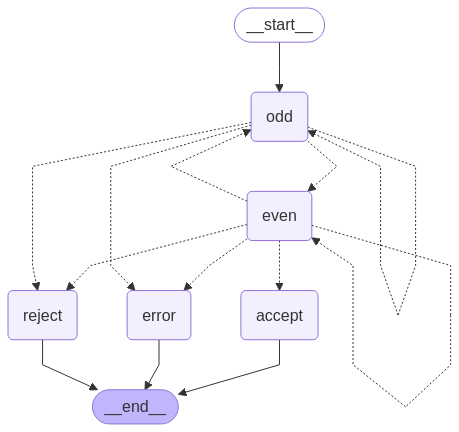

In [7]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print(f"グラフの描画中にエラーが発生しました: {e}") # 描画中に発生したエラーを出力する
    pass

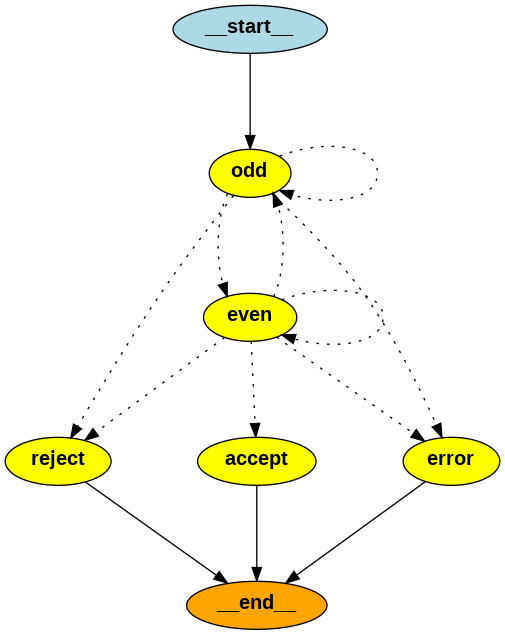

In [8]:
try:
    display(Image(graph.get_graph().draw_png()))
except Exception:
    print(f"グラフの描画中にエラーが発生しました: {e}") # 描画中に発生したエラーを出力する
    pass

In [9]:
graph.invoke({"input": "11"}, debug=True) # 偶数 : 拒否

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'input': '11'}
[0:writes] Finished step 0 with writes to 1 channel:
- input -> '11'
[0:checkpoint] State at the end of step 0:
{'input': '11'}
[1:tasks] Starting 1 task for step 1:
- odd -> {'input': '11'}
[1:writes] Finished step 1 with writes to 2 channels:
- input -> '1'
- character -> '1'
[1:checkpoint] State at the end of step 1:
{'character': '1', 'input': '1'}
[2:tasks] Starting 1 task for step 2:
- even -> {'character': '1', 'input': '1'}
[2:writes] Finished step 2 with writes to 2 channels:
- input -> ''
- character -> '1'
[2:checkpoint] State at the end of step 2:
{'character': '1', 'input': ''}
[3:tasks] Starting 1 task for step 3:
- odd -> {'character': '1', 'input': ''}
[3:writes] Finished step 3 with writes to 2 channels:
- input -> ''
- character -> None
[3:checkpoint] State at the end of step 3:
{'character': None, 'input': ''}
[4:tasks] Starting 1 task for step 4:
- re

{'input': '', 'character': None, 'result': 'reject'}

In [10]:
graph.invoke({"input": "1"}) # 奇数 : 受理

-- accept! --


{'input': '', 'character': None, 'result': 'accept'}

In [11]:
graph.invoke({"input": "01010"}) # 偶数 : 拒否

-- reject! --


{'input': '', 'character': None, 'result': 'reject'}

In [12]:
graph.invoke({"input": "11111"}) # 奇数 : 受理

-- accept! --


{'input': '', 'character': None, 'result': 'accept'}

In [13]:
graph.invoke({"input": ""}) # 偶数 : 拒否

-- reject! --


{'input': '', 'character': None, 'result': 'reject'}

In [14]:
graph.invoke({"input": "1a"}) # 異常系 : エラー

-- error! --


{'input': '', 'character': 'a', 'result': 'error'}